![](https://www.math.unipd.it/~marcuzzi/BannerStrumentifondamentali.png)

# Decomposizione LU e fill-in

Supponiamo di dover risolvere il sistema lineare $$Ax = b,$$
dove $A$ è una matrice $n \times n$ sparsa ed invertibile. Da un punto di vista teorico, è naturale scrivere 
$$x = A^{-1}b,$$ tuttavia questo non significa che sia una buona idea calcolare $A^{-1}$. Anzi, in generale non lo è mai! Vediamo perchè...

In [1]:
import numpy as np
from scipy.io import mmread
import scipy
import scipy.sparse.linalg as sla
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

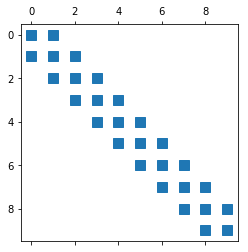

In [2]:
n = 10
diags = np.array([0, -1, 1])
data  = np.array([[2]*n, [1]*(n), [1]*(n)])

A = scipy.sparse.spdiags(data, diags, n, n, format = 'csc')
plt.spy(A)

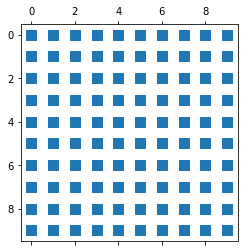

In [3]:
Ainv = sla.inv(A)
plt.spy(Ainv)

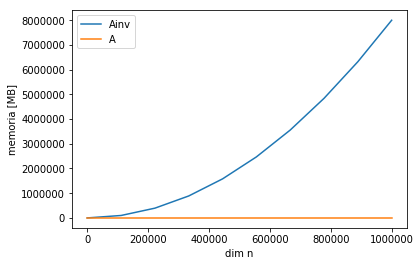

In [4]:
x = np.linspace(0, 1e6, 10)
plt.plot(x, 8.0 * (x**2) / 1e6) #Ainv
plt.plot(x, 8.0 * (3*x) / 1e6) #A
plt.xlabel("dim n")
plt.ylabel("memoria [MB]")
plt.legend(['Ainv', 'A'])
plt.show()

In generale, l'inversa di una matrice sparse è densa. In molte applicazioni si richiede di risolvere il sistema $Ax = b$ anche se non c'è neanche memoria sufficiente per salvare $A^{-1}$. Per esempio, supponiamo che $n = 1\ 000\ 000$ e che la matrice sparsa $A$ sia tridiagonale, come nell'esempio sopra. In questo caso $A$ ha $n*2*(n-1)$ elementi diversi da zero, circa $3$ milioni. Abbiamo visto diverse maniere di memorizzare $A$ in maniera efficiente, ma in generale $A^{-1}$ sarà densa, cioè quasi tutte le $1\ 000\ 000\ 000\ 000$ di entrate saranno diverse da zero! In questo caso, memorizzare la matrice $A$ richiede qualche megabyte di memoria, ma salvare $A^{-1}$ richederebbe dei terabyte di memoria!

# Decomposizione LU

La decomposizione LU con pivoting parziale è la tecnica principale per risolvere un sistema lineare con matrice densa. L'idea è quella di trovare una decomposizione della matrice del sistema 
$$ A = P^TLU,$$
dove $L$ è una matrice triangolare inferiore, $U$ è una matrice triangolare superiore e $P$ è una matrice di permutazione necessaria perchè l'algoritmo sia stabile (ricorda che la decomposizione LU si può calcolare con l'eliminazione di Gauss: la permutazione di righe è necessaria qualora si incontrasse un pivot vicino allo zero).

Anche per i sistemi lineari la cui matrice è sparsa, la decomposizione LU risulta uno strumento efficace e potente. Infatti Python utilizza di default il solutore SuperLU. SuperLU può risolvere sistemi di numeri reali o complessi in singola e doppia precisione. SuperLU viene automaticamente sostituito da UMFPACK, se quest'ultimo è disponibile.

- `spsolve` risolve un sistema lineare $Ax=b$ chiamando SuperLU (o umfpack)

In [5]:
#membro destro
b = np.ones(n)

In [6]:
x = sla.spsolve(A, b)
print("|| Ax-b || = ", (np.linalg.norm(A*x - b)))

|| Ax-b || =  0.0


-  `splu` calcola la decomposizione LU con pivoting totale di una matrice sparsa
    $$ A = P^TLUQ^T,$$
    dove $P,L,U$ sono come sopra e $Q$ è la matrice di permutazione delle colonne. Possiamo specificare la permutazione desiderata tramite la keyword `permc_spec`. Noi scegliamo `perm_spec = 'NATURAL'` (nessuna permurazione).

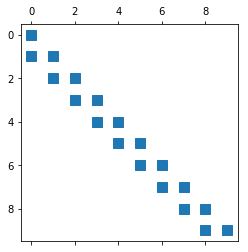

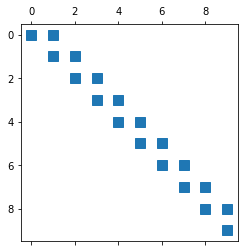

In [7]:
LU = sla.splu(A, permc_spec = 'NATURAL')
plt.figure()
plt.spy(LU.L)
plt.figure()
plt.spy(LU.U)

In [8]:
x = LU.solve(b)
print("|| Ax-b || = ", (np.linalg.norm(A*x - b)))

|| Ax-b || =  1.1102230246251565e-16


In [9]:
print(LU.perm_r, LU.perm_c)

[0 1 2 3 4 5 6 7 8 9] [0 1 2 3 4 5 6 7 8 9]


# Fill-in

Nella decomposizione LU con pivoting totale di una matrice sparsa
 $$ A = P^TLUQ^T,$$
Nella decomposizione LU con pivoting parziale, il riordinamento delle righe $P$ è necessario assicurare la stabilità dell'algoritmo. Nella decomposizione LU con pivoting totale, il riordinamento delle colonne $Q$ serve a far sì che i fattori $L,U$ siano anch'essi sparsi. 

Un *fill-in* (*riempimento* in italiano) è un elemento non nullo che compare nei fattori di una decomposizione lì dove nella matrice originale c'era invece uno zero. 
Vediamo un esempio semplice nel quale possiamo osservare il fill-in.

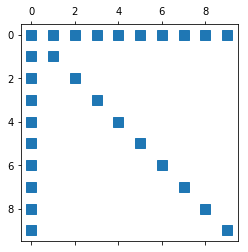

In [10]:
A       = 2*scipy.sparse.eye(n).tolil()
A[0,1:] = np.ones(n-1)
A[1:,0] = np.ones((n-1,1))
A = A.tocsc()

plt.spy(A)

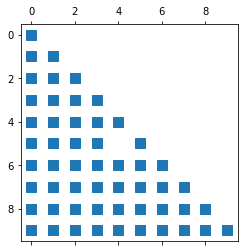

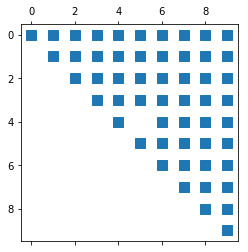

In [11]:
LU = sla.splu(A, permc_spec = 'NATURAL') #solo permutazione delle righe
plt.figure()
plt.spy(LU.L)
plt.figure()
plt.spy(LU.U)

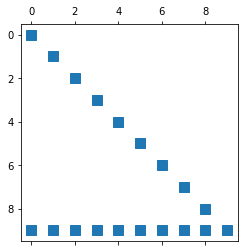

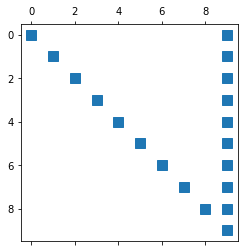

In [12]:
LU = sla.splu(A) #con permutazione delle colonne, default: permc_spec = 'COLAMD'
plt.figure()
plt.spy(LU.L)
plt.figure()
plt.spy(LU.U)

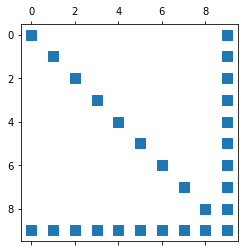

In [13]:
P = coo_matrix((np.ones(n), (LU.perm_r, np.arange(n))) ).tocsc()
Q = coo_matrix((np.ones(n), (np.arange(n), LU.perm_c)) ).tocsc()

Aperm = P*A*Q
plt.spy(Aperm)

# Il riorninamento RCM

In generale, è molto difficile evitare completamente la creazione di fill-in (trovare la permutazione ottimale per una data matrice è un problema NP-completo!). Tuttavia esistono delle tecniche *general purpose* per limitare il fill-in, uno di questi è l'algoritmo *reverse Cuthill-Mckee* (RCM). Questo algoritmo nasce nell'ambito della **teoria dei grafi**, infatti è possibile vedere una certa matrice sparsa come la matrice di adiacenza di un grafo finito: dato un grafo (G,V), la matrice di adiacenza è una matrice quadrata la cui dimensione è uguale al numeri di vertici del grafo e in cui l'elemento $(i,j)$ è dioverso da zero se e solo se c'è un arco dal nodo $i$ al nodo $j$. L'algoritmo cambia l'enumerazione dei vertici del grafo, in maniera tale che la matrice di adiacenza sia a banda. Questa operazione si traduce a livello matriciale in una serie di permutazioni di righe e colonne. L'algoritmo RCM si applica tipicamente alle matrici simmetriche; se invece la matrice non è simmetrica, l'algoritmo lavora sulla matrice $A+A^T$.

In [19]:
from scipy.sparse.csgraph import reverse_cuthill_mckee as rcm
from scipy.io import mmread

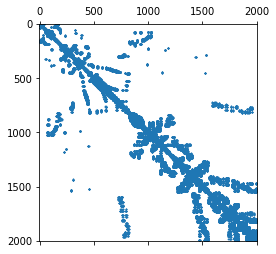

In [20]:
cartella = './matrici_test/'
A = mmread(cartella+'bcsstk13.mtx').tocsc()
plt.spy(A, markersize = 0.7)

In [21]:
perm = rcm(A, symmetric_mode=True) #RCM sulla matrice simmetrica A

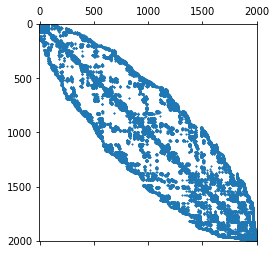

In [22]:
# In Aperm l'elemento (i,j) e' l'elemento (perm[i], perm[j]) di A
Aperm = A[perm,:][:,perm]
plt.spy(Aperm, markersize = 0.7)#, symmetric_mode=True)

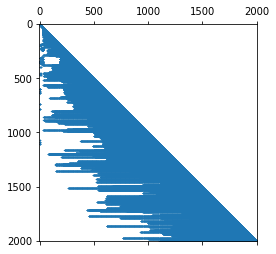

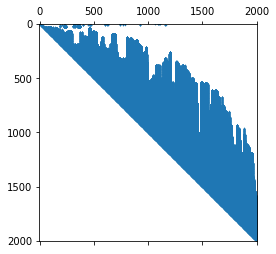

In [23]:
LU = sla.splu(Aperm, permc_spec = 'NATURAL') #solo permutazione delle righe
plt.figure()
plt.spy(LU.L,markersize = 0.5)
plt.figure()
plt.spy(LU.U,markersize = 0.5)

Quest'algoritmo è utile in quanto il pattern delle matrici sparse provenienti dai problemi reali spesso hanno pattern strutturati, ma abbastanza complessi per studiare un algoritmo che ritorni il pattern ottimale per una decomposizione LU nel senso di minimizzare il fill-in (questo problema è stato dimostrato essere **NP-completo**). Tuttavia nelle matrici a banda il fill-in si concentra all'interno della banda e questo permette di avere una stima a priori sulla memoria necessaria. 